# Modelo: Local-Sydney

In [ ]:
! jupyter nbconvert --to html 6_Modelo_Local.ipynb

[NbConvertApp] Converting notebook 6_Modelo_Local.ipynb to html
[NbConvertApp] Writing 725358 bytes to 6_Modelo_Local.html


In [ ]:
import pandas as pd
import collections
from typing import List, Dict, Union, Tuple

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn import metrics
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Creando un tipo de objeto para los clasificadores
ModelRegressor = Union[SVC, KNeighborsClassifier, DecisionTreeClassifier,
                       GaussianNB, MultinomialNB, ComplementNB,
                       LogisticRegression, XGBClassifier]



%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display

import os
import sys

# Agregar mi librería personalizada de python
module_path = os.path.abspath(os.path.join(os.getcwd().replace('notebooks', 'src')))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import rain
import importlib

def reload():
    """" Used to reload the modules"""
    libs_list = [rain]
    for lib in libs_list:
        importlib.reload(lib)

    print("Reload complete")

## Objetivo del notebook

En este notebook, desarrollaré un modelo local, para lo cual seleccionare una ciudad, para posteriormente realizar una comparación basada en el rendimiento del modelo a través de la métrica F1-score.

<br>


In [ ]:
file = r'..\data\weatherAUS.csv'
# Leyendo el dataset
df = rain.read_weather(file)

In [ ]:
df.groupby('Location')['RainTomorrow'].count().sort_values(ascending=False).head()

Location
Canberra    3418
Sydney      3337
Perth       3193
Darwin      3192
Hobart      3188
Name: RainTomorrow, dtype: int64

Elegiré Sydney, debido a que es la ciudad más conocida de Australia

In [ ]:
df_sydney = df[df.Location == 'Sydney']
df_sydney.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,SSW,17.0,20.0,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,2008,2
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,E,9.0,13.0,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,2008,2
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,ESE,17.0,2.0,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,2008,2
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,E,22.0,20.0,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,2008,2
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,W,11.0,6.0,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,2008,2


In [ ]:
# Indices que corresponden a la ciudad de Sydney
idx_sydney = df_sydney.index.to_list()

In [ ]:
reload()

Reload complete


In [ ]:
reload()

drop_columns = ['MinTemp', 'Pressure3pm', 'Temp9am', 'Temp3pm', # Multicolineadlidad
                'WindGustDir', 'WindDir9am', 'WindDir3pm', # Alta cardinalidad
                'Location', 'Date', 'month', 'year', # Sin importancia para el modelo
               'month_cos', # tiene mejor desempeño month_sin
               ]

X_train, y_train, X_test, y_test = rain.pipline_process_data(drop_columns=drop_columns)

Reload complete


**Seleccionando la ciudad de Sidney**

In [ ]:
X_train = X_train[X_train.index.isin(idx_sydney)]
X_test = X_test[X_test.index.isin(idx_sydney)]

In [ ]:
y_train = y_train[y_train.index.isin(idx_sydney)]
y_test = y_test[y_test.index.isin(idx_sydney)]

**Proporción de datos por etiqueta**

In [ ]:
# Datos de entrenamiento
round(y_train.value_counts() / len(y_train) * 100, 0)

0    75.0
1    25.0
Name: RainTomorrow, dtype: float64

In [ ]:
# Datos de Prueba
round(y_test.value_counts() / len(y_test) * 100, 0)

0    71.0
1    29.0
Name: RainTomorrow, dtype: float64

### Prueba inicial con XGBoost

In [ ]:
df2= rain.modeling_by_xgb_importance(model_name='XGBoost', model=XGBClassifier(n_jobs=-1),
                                     x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)

In [ ]:
df2.head(10)

,Models,Id,No_features,ROC,ROC_AUC,F1,Recall,Accuracy,Brier,Importance_type,Best_features
0,XGBoost,model_54,12,0.76,0.84,67.0,57.0,84.0,16.0,cover,"Pressure9am,Rainfall,Evaporation,month_sin,Win..."
1,XGBoost,model_2,12,0.75,0.85,66.0,56.0,83.0,17.0,total_gain,"month_sin,WindSpeed9am,WindSpeed3pm,Cloud3pm,R..."
2,XGBoost,model_15,12,0.75,0.85,66.0,56.0,84.0,16.0,total_cover,"WindSpeed9am,Cloud9am,Rainfall,WindSpeed3pm,Cl..."
3,XGBoost,model_28,12,0.75,0.85,66.0,56.0,83.0,17.0,weight,"month_sin,Cloud3pm,Rainfall,WindSpeed9am,WindS..."
4,XGBoost,model_41,12,0.75,0.85,66.0,57.0,83.0,17.0,gain,"Evaporation,Pressure9am,Cloud9am,WindSpeed3pm,..."
5,XGBoost,model_55,11,0.76,0.84,66.0,59.0,83.0,17.0,cover,"Rainfall,Evaporation,month_sin,WindSpeed3pm,Hu..."
6,XGBoost,model_6,8,0.75,0.84,66.0,57.0,83.0,17.0,total_gain,"Rainfall,Evaporation,WindGustSpeed,Humidity9am..."
7,XGBoost,model_16,11,0.75,0.84,65.0,57.0,83.0,17.0,total_cover,"Cloud9am,Rainfall,WindSpeed3pm,Cloud3pm,Evapor..."
8,XGBoost,model_4,10,0.74,0.83,65.0,55.0,83.0,17.0,total_gain,"WindSpeed3pm,Cloud3pm,Rainfall,Evaporation,Win..."
9,XGBoost,model_17,10,0.74,0.83,65.0,55.0,83.0,17.0,total_cover,"Rainfall,WindSpeed3pm,Cloud3pm,Evaporation,Win..."


### Realizando la comprobación de los resultados

In [ ]:
best_features = df2.Best_features.iloc[0].split(',')

Las características que contribuyeron al mejor modelo son:

In [ ]:
best_features

['Pressure9am',
 'Rainfall',
 'Evaporation',
 'month_sin',
 'WindSpeed3pm',
 'Humidity9am',
 'Cloud9am',
 'WindGustSpeed',
 'MaxTemp',
 'Cloud3pm',
 'Humidity3pm',
 'Sunshine']

In [ ]:
model = XGBClassifier(n_jobs=-1)

In [ ]:
model.fit(X_train[best_features], y_train)

[03:16:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\PDN\venvs\venv_rain\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
print(classification_report(y_train, model.predict(X_train[best_features])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1874
           1       1.00      1.00      1.00       625

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499



En este caso existe un sobre entrenamiento (Overfitting) de los resultados, ya que tiene un buen desempeño durante el entrenamiento del modelo, pero su desempeño disminuye cuando se pone a prueba

In [ ]:
y_pred = model.predict(X_test[best_features])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       598
           1       0.80      0.57      0.67       240

    accuracy                           0.84       838
   macro avg       0.82      0.76      0.78       838
weighted avg       0.83      0.84      0.83       838



In [ ]:
f1 = round(metrics.f1_score(y_test, y_pred) * 100)

print(f'El score conseguido fue: {f1} [F1-score]')

El score conseguido fue: 67 [F1-score]


### Segunda prueba inicial con Regresión Logistica

In [ ]:
df2= rain.modeling_by_xgb_importance(model_name='LOGISTIC REGRESSION', model=LogisticRegression(random_state=0),
                                     x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)

In [ ]:
df2.head(10)

,Models,Id,No_features,ROC,ROC_AUC,F1,Recall,Accuracy,Brier,Importance_type,Best_features
0,LOGISTIC REGRESSION,model_6,8,0.75,0.86,66.0,57.0,83.0,17.0,total_gain,"Rainfall,Evaporation,WindGustSpeed,Humidity9am..."
1,LOGISTIC REGRESSION,model_15,12,0.75,0.86,65.0,56.0,82.0,18.0,total_cover,"WindSpeed9am,Cloud9am,Rainfall,WindSpeed3pm,Cl..."
2,LOGISTIC REGRESSION,model_41,12,0.75,0.86,65.0,56.0,82.0,18.0,gain,"Evaporation,Pressure9am,Cloud9am,WindSpeed3pm,..."
3,LOGISTIC REGRESSION,model_54,12,0.75,0.86,65.0,56.0,82.0,18.0,cover,"Pressure9am,Rainfall,Evaporation,month_sin,Win..."
4,LOGISTIC REGRESSION,model_16,11,0.74,0.86,65.0,56.0,82.0,18.0,total_cover,"Cloud9am,Rainfall,WindSpeed3pm,Cloud3pm,Evapor..."
5,LOGISTIC REGRESSION,model_30,10,0.75,0.86,65.0,56.0,82.0,18.0,weight,"Rainfall,WindSpeed9am,WindSpeed3pm,WindGustSpe..."
6,LOGISTIC REGRESSION,model_1,13,0.74,0.86,64.0,55.0,82.0,18.0,total_gain,"Cloud9am,month_sin,WindSpeed9am,WindSpeed3pm,C..."
7,LOGISTIC REGRESSION,model_14,13,0.74,0.86,64.0,55.0,82.0,18.0,total_cover,"month_sin,WindSpeed9am,Cloud9am,Rainfall,WindS..."
8,LOGISTIC REGRESSION,model_27,13,0.74,0.86,64.0,55.0,82.0,18.0,weight,"Cloud9am,month_sin,Cloud3pm,Rainfall,WindSpeed..."
9,LOGISTIC REGRESSION,model_40,13,0.74,0.86,64.0,55.0,82.0,18.0,gain,"WindSpeed9am,Evaporation,Pressure9am,Cloud9am,..."


### Realizando la comprobación de los resultados

In [ ]:
best_features = df2.Best_features.iloc[0].split(',')

Las características que contribuyeron al mejor modelo son:

In [ ]:
best_features

['Rainfall',
 'Evaporation',
 'WindGustSpeed',
 'Humidity9am',
 'Pressure9am',
 'MaxTemp',
 'Humidity3pm',
 'Sunshine']

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
model.fit(X_train[best_features], y_train)

LogisticRegression(random_state=0)

In [ ]:
print(classification_report(y_train, model.predict(X_train[best_features])))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1874
           1       0.73      0.54      0.62       625

    accuracy                           0.84      2499
   macro avg       0.79      0.74      0.76      2499
weighted avg       0.83      0.84      0.83      2499



In [ ]:
y_pred = model.predict(X_test[best_features])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89       598
           1       0.77      0.57      0.66       240

    accuracy                           0.83       838
   macro avg       0.81      0.75      0.77       838
weighted avg       0.82      0.83      0.82       838



In [ ]:
f1 = round(metrics.f1_score(y_test, y_pred) * 100)

print(f'El score conseguido fue: {f1} [F1-score]')

El score conseguido fue: 66 [F1-score]


### Hiperparamétrización [con los mejores atributos]

In [ ]:
logreg = LogisticRegression(random_state=0)

logreg_params = {
    'C': np.arange(0.1, 10, .2),
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [0]
}

logreg_gs = GridSearchCV(logreg, logreg_params, scoring='f1', n_jobs=-1, cv=5)
logreg_gs.fit(X_train[best_features], y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9]),
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'random_state': [0]},
             scoring='f1')

In [ ]:
logreg_gs.best_params_

{'C': 5.700000000000001,
 'fit_intercept': True,
 'max_iter': 50,
 'random_state': 0}

In [ ]:
round(logreg_gs.best_score_, 4)

0.6209

In [ ]:
y_pred_logreg_gs = logreg_gs.predict(X_test[best_features])

In [ ]:
print(classification_report(y_train, logreg_gs.predict(X_train[best_features])))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1874
           1       0.73      0.54      0.62       625

    accuracy                           0.84      2499
   macro avg       0.80      0.74      0.76      2499
weighted avg       0.83      0.84      0.83      2499



In [ ]:
y_pred = model.predict(X_test[best_features])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89       598
           1       0.77      0.57      0.66       240

    accuracy                           0.83       838
   macro avg       0.81      0.75      0.77       838
weighted avg       0.82      0.83      0.82       838



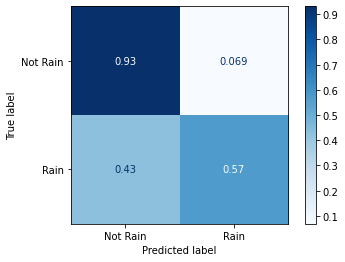

In [ ]:
rain.plot_cm(model, X_test[best_features], y_test)

In [ ]:
round(f1_score(y_test, y_pred), 2)

0.66

**Conclusión**:

- Aunque XGBoost logró un desempeño del 67% en F1-Score, este se encontraba sobre entrenado
- Hubo una mejora significativa en comparación del modelo 'Nacional' y el modelo 'Local-Sydney' ya que este último con una Regresión Logistica alcanzó un desempeño de 66% tanto en 'entrenamiento' como en 'pruebas', mientras que el 'Nacional' obtuvo una puntuación entre 61% con XGBoost.

**Conclusiones generales**

- El modelo base 'Nacional' cuenta con un desempeño aceptable, con un 61% en F1. 
- Aunque probé distintos algoritmos de clasificación, además de una ingeniería para la selección de atributos, no fue posible superar el 61% en F1 en el modelo 'Nacional', lo que me lleva a pensar que es necesario mejorar el procesamiento y análisis de los datos.
- Los modelos locales son más prometedores que un modelo 'Nacional'. 

**Recomendaciones:**

- Aún quedan muchos análisis que realizar y ajustes para mejorar el modelo, como por ejemplo: un mejor manejo en las variables categóricas, profundizar en la distribución de la información, análisis y procesamiento de los datos a nivel local e incluso un análisis enfocado en la temporada de lluvias.
- Para un enfoque regional, podría llevarse a cabo una clusterización que agrupe las ciudades con condiciones climatológicas similares.
- Mejorar el conocimiento del fénomeno de precipitación en Australia
- También podría mejorarse el desempeño del modelo a través de técnicas de ensamblado de modelos.